### Описание проекта
Анализ клиентских реакций

Цель: выявить, какие фразы менеджеров вызывают позитивные и негативные реакции клиентов, и как это связано с оценками.

Задачи:
 1. Получить таблицу: звонок → реплики менеджера → реплики клиента.
 2. Очистить текст и выделить клиентские реплики.
 3. Провести тональный анализ: позитив / нейтрально / негатив.
 4. Сопоставить тональность с итоговой оценкой звонка.
 5. Составить таблицу: «фраза менеджера → реакция клиента → оценка звонка».
 6. Составить топ-10 успешных фраз (вызвали позитив и высокую оценку).
 7. Составить топ-10 опасных фраз (вызвали негатив и низкую оценку).
 8. Сделать облако слов для позитивных и негативных реакций.

Выходные артефакты:
 • Таблица фраз и реакций,
 • Визуализация (облака слов),
 • Отчёт (1–2 страницы).
 

#### 1. Изучение общей информации

In [1]:

import pandas as pd
import numpy as np
import torch
import transformers
from tqdm import notebook
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from transformers import BertTokenizer
from transformers import BertConfig
from transformers import BertModel
from sklearn.model_selection import train_test_split

In [2]:

import nltk
import re
from transformers import pipeline
from nltk.corpus import stopwords
from collections import Counter
import pymorphy2
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
import csv

In [4]:
warnings.filterwarnings('ignore')

In [5]:
RANDOM_STATE = 42

In [11]:
#csv.field_size_limit(1000000)

In [18]:
data=pd.read_csv('C:\\Users\\N\\Documents\\Документы\\Data science\\Карьерный трек\\Aimy\\101.csv')
data.head()

,Unnamed: 0,text,role
0,0,"Доброго дня, магазин ДФС, отдел наставки",1
1,1,Был пропущен звоночек от вас,1
2,2,"Да, здрасте",0
3,3,"Я хотела уточнить, подскажите, вот почему на с...",0
4,4,"А в чем разница, почему так",0


In [12]:
#data.to_excel('C:\\Users\\N\\Documents\\Документы\\Data science\\Карьерный трек\\Aimy\\whisperX\\diarization_new.xlsx', index=True)

#### 2. Подготовка данных

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1360 entries, 0 to 1359
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1360 non-null   int64 
 1   text        1360 non-null   object
 2   role        1360 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 32.0+ KB


 Пропусков в данных нет.

In [20]:
data.duplicated().sum()

0

In [21]:
data = data.drop_duplicates(subset=['text'])

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1276 entries, 0 to 1358
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1276 non-null   int64 
 1   text        1276 non-null   object
 2   role        1276 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 39.9+ KB


Проверим целевой признак на сбалансированность классов.

In [23]:
data['role'].value_counts(normalize=True) 

role
1    0.648119
0    0.351881
Name: proportion, dtype: float64

Данные очевидно несбалансированы. Это будет необходимо учесть при делении выбоки на обучающую и тестовую.

Построим векторы текстов с помощью предобученной модели BERT.
Для применения модели Bert необходимо уменьшить размер выборки, иначе она будет очень долго обрабатываться.
Для корректной работы модели необходимо, чтобы количество токенов было не более 512, для этого оставим в выборке только строки с количеством символов не более 1800 (тк одно слово обычно содержит около 3-4 токенов).

In [24]:
data['len'] = data['text'].str.len()
data_bert = data.query('len < 1800')

In [25]:
data_bert.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1276 entries, 0 to 1358
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1276 non-null   int64 
 1   text        1276 non-null   object
 2   role        1276 non-null   int64 
 3   len         1276 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 49.8+ KB


In [26]:

data_bert = data_bert.sample(1200).reset_index(drop=True)

Применим предобученную модель 'unitary/toxic-bert'.
Инициализируем токенизатор как объект класса BertTokenizer.
Преобразуем текст в номера токенов из словаря методом encode().
Применим метод padded, чтобы после токенизации длины исходных текстов в корпусе были равными. 
Отбросим нулевые токены и «создадим маску» для действительно важных токенов, то есть укажем нулевые и не нулевые значения.

In [27]:
tokenizer = BertTokenizer.from_pretrained('seara/rubert-tiny2-russian-sentiment')

tokenized = data_bert['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)
print(padded.shape)
print(attention_mask.shape)

(1200, 107)
(1200, 107)


Инициализируем конфигурацию BertConfig. Передадим ей файл с предобученной моделью и конфигурацией.

In [21]:
config = BertConfig.from_pretrained('seara/rubert-tiny2-russian-sentiment')
model = BertModel.from_pretrained('seara/rubert-tiny2-russian-sentiment', config=config)

Преобразуем текст в эмбеддинги.
Чтобы хватило оперативной памяти, сделаем размер батча 100.
Преобразуем данные в формат тензоров - многомерных векторов в библиотеке torch.
Передадим модели данные и маску. 
Для ускорения вычисления функцией no_grad() в библиотеке torch укажем, что градиенты не нужны.

In [22]:
batch_size = 100
embeddings = []


for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/12 [00:00<?, ?it/s]

Соберём все эмбеддинги в матрицу признаков.

In [23]:
features = np.concatenate(embeddings)


In [24]:
features.shape

(1200, 312)

Разделим выборку на обучающую и тестовую с учетом стратификации.

In [113]:
X_train, X_test, y_train, y_test = train_test_split(
    features,
    data_bert['role'],
    test_size = 0.25, 
    random_state = 42, stratify=data_bert['role'])


#### 3. Обучение моделей

Обучим 4 разных модели: KNN, DecisionTreeClassifier, LogisticRegression, LightGBM, с помощью пайплайна зададим разные гиперпараметры и применим RandomSearchCV для поиска лучшей метрики F1_score на кросс-валидации.

In [114]:
pipe_final = Pipeline([
    #('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [115]:
param_distributions = [
    
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,7),
           
    },
   
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__min_samples_leaf': range(1, 6),
        'models__min_samples_split': range(2, 6),
           
    },
        
   
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')],
        'models__C': range(1,5),
        'model__penalty': ['l1', 'l2']
       }

        
] 

In [116]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions, 
    cv=5,
    scoring='f1', 
    n_jobs=-1,
    random_state=RANDOM_STATE
)

In [117]:
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_params_)
print ('Метрика лучшей модели на кросс-валидации:', round(randomized_search.best_score_,2))

Лучшая модель и её параметры:

 Pipeline(steps=[('models',
                 DecisionTreeClassifier(max_depth=2, min_samples_leaf=3,
                                        min_samples_split=4,
                                        random_state=42))])
Метрика лучшей модели на кросс-валидации: {'models__min_samples_split': 4, 'models__min_samples_leaf': 3, 'models__max_depth': 2, 'models': DecisionTreeClassifier(random_state=42)}
Метрика лучшей модели на кросс-валидации: 0.75


In [118]:
model_best = randomized_search.best_estimator_
predictions = model_best.predict(X_test)
f1_test = f1_score(y_test, predictions)
print(f"F1 на тестовой выборке: {f1_test:.2f}")

F1 на тестовой выборке: 0.72


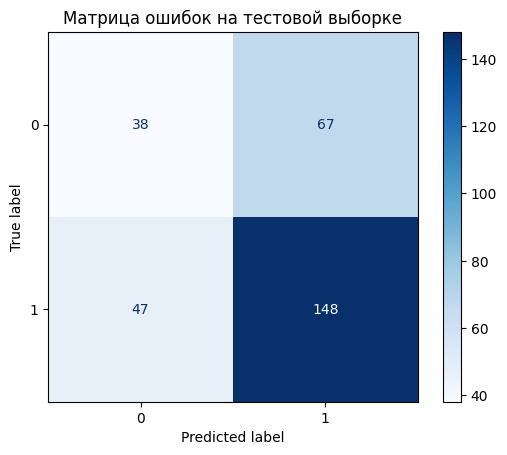

In [119]:
ConfusionMatrixDisplay.from_estimator(model_best, X_test, y_test, cmap='Blues')
plt.title('Матрица ошибок на тестовой выборке');
plt.show() 

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    features,
    data_bert['role'],
    test_size = 0.25, 
    random_state = 42, stratify=data_bert['role'])


In [32]:
param_distributions = [
          
    {  
      'n_estimators': [100,500,1500],
      'max_depth': range(1,10),
      'learning_rate': [0.01, 0.03, 0.05, 0.1],
     
}
]

In [33]:
lgb_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, 
                              random_state=RANDOM_STATE, verbosity = -1)


In [34]:
randomized_search = RandomizedSearchCV(
    lgb_model, 
    param_distributions, 
    cv=3,
    scoring='f1',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    error_score='raise'
    

)


In [35]:
randomized_search.fit(X_train, y_train) 
print('Лучшая модель LGBM и её параметры:\n\n', randomized_search.best_estimator_)
#print('Гиперпараметры', randomized_search.best_params_)
lgbm_f1=round(randomized_search.best_score_,2)

print ('Метрика лучшей модели LGBM на кросс-валидации:', lgbm_f1)

Лучшая модель LGBM и её параметры:

 LGBMClassifier(learning_rate=0.03, max_depth=7, random_state=42, verbosity=-1)
Метрика лучшей модели LGBM на кросс-валидации: 0.79


In [36]:
model_best_LGBM = randomized_search.best_estimator_

In [37]:
predictions = model_best_LGBM.predict(X_test)
f1_test = f1_score(y_test, predictions)
print(f"F1 на тестовой выборке: {f1_test:.2f}")

F1 на тестовой выборке: 0.81


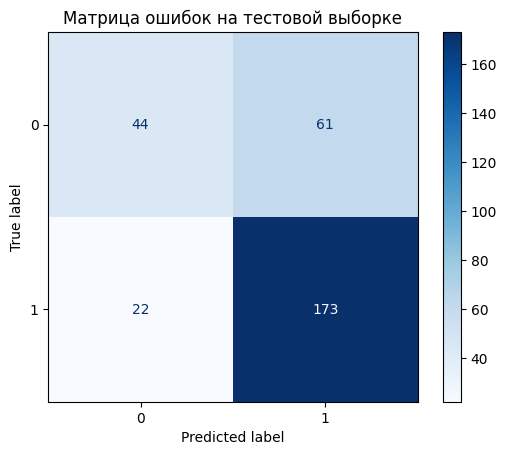

In [38]:
ConfusionMatrixDisplay.from_estimator(model_best_LGBM, X_test, y_test, cmap='Blues')
plt.title('Матрица ошибок на тестовой выборке');
plt.show() 

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    features,
    data_bert['role'],
    test_size = 0.25, 
    random_state = 42, stratify=data_bert['role'])

In [40]:
param_distributions = [
          
    {  
      
      'max_depth': range(1,10),
      'iterations': [500, 1000, 1500],
      'learning_rate': [0.01, 0.03, 0.05, 0.1],
      'l2_leaf_reg': [1, 3, 5, 10],
      'border_count': [32, 64, 128],
      'random_strength': [0.5, 1, 2],
      'bagging_temperature': [0, 0.5, 1],
      'scale_pos_weight': [1, 2, 3]}  # если дисбаланс классов}
    

]

In [41]:
#cat_features = ['features'] 
catb_model = CatBoostClassifier(early_stopping_rounds=50, random_state=RANDOM_STATE, verbose=False) 

In [42]:
randomized_search = RandomizedSearchCV(
    catb_model, 
    param_distributions, 
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    error_score='raise'


)

In [ ]:
randomized_search.fit(X_train, y_train) 
print('Лучшая модель CatBoost и её параметры:\n\n', randomized_search.best_estimator_)
print('Гиперпараметры', randomized_search.best_params_)
catb_f1=round(randomized_search.best_score_,2)

print ('Метрика лучшей модели CatBoost на кросс-валидации:', catb_f1)

In [ ]:
model_best_CatBoost = randomized_search.best_estimator_
predictions = model_best_CatBoost.predict(X_test)
f1_test = f1_score(y_test, predictions)
print(f"F1 на тестовой выборке: {f1_test:.2f}")

In [ ]:
ConfusionMatrixDisplay.from_estimator(model_best_CatBoost, X_test, y_test, cmap='Blues')
plt.title('Матрица ошибок на тестовой выборке');
plt.show() 

Итак, лучшая модель - LGBMClassifier(learning_rate=0.03, max_depth=7, random_state=42)
Метрика лучшей модели LGBM на кросс-валидации: 0.79, на тесте - 0.81

### 1. Получить таблицу: звонок → реплики менеджера → реплики клиента.

In [46]:
df=pd.read_csv('C:\\Users\\N\\Documents\\Документы\\Data science\\Карьерный трек\\Aimy\\Coursor\\1000.csv')
df.head(10)

,id,created_at,call_type,transcription,score
0,1,9/16/2025 21:00,REGULAR,"[{""text"": ""Алло. Доброго дня, магазин ДФС, отд...",6.67
1,2,9/16/2025 21:00,REGULAR,"[{""text"": ""Добрый день. Мы это магазин гос. от...",7.33
2,3,9/16/2025 21:00,REGULAR,"[{""text"": ""Магазин ДФС. Дело доставки. По ваше...",5.67
3,4,9/16/2025 21:00,REGULAR,"[{""text"": ""Спасибо. Добрый день, магазин ДФС, ...",4.00
4,5,9/16/2025 21:00,REGULAR,"[{""text"": ""Алло, продолжаю дозвониться."", ""end...",1.00
5,6,9/16/2025 21:00,REGULAR,"[{""text"": ""Проводня магазин ДСС, меня зовут Ал...",4.33
6,7,9/16/2025 21:00,REGULAR,"[{""text"": ""Доброго дня, магазин ДФС, меня зову...",6.33
7,8,9/16/2025 21:00,REGULAR,"[{""text"": ""Добрый день, скажите, у вас витамин...",8.00
8,9,9/16/2025 21:00,REGULAR,"[{""text"": ""Номер не отвечает."", ""end_time"": 6....",0.00
9,10,9/16/2025 21:00,REGULAR,"[{""text"": ""Здравствуйте! Вызываемый абонент се...",0.00


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             986 non-null    int64  
 1   created_at     986 non-null    object 
 2   call_type      986 non-null    object 
 3   transcription  986 non-null    object 
 4   score          986 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 38.6+ KB


In [48]:
df=df.loc[df['score']!=0]
df['score'].unique()

array([6.67, 7.33, 5.67, 4.  , 1.  , 4.33, 6.33, 8.  , 4.67, 9.  , 8.33,
       6.  , 5.33, 3.33, 1.67, 2.67, 1.33, 5.  , 3.67, 2.33, 3.  , 9.33,
       0.67, 0.33, 2.  , 7.67, 5.25, 4.25, 4.63, 2.25, 1.25, 2.63, 4.13,
       6.88, 1.63, 2.38, 3.75, 2.75, 3.5 , 2.13, 6.5 , 1.75, 7.38, 3.13,
       5.63, 5.75, 6.13, 3.88, 0.75, 0.5 , 0.63, 4.75, 6.63, 7.13, 7.  ,
       7.75, 3.63, 7.63, 3.38, 4.88, 3.25, 4.38, 5.88, 7.5 , 6.75, 5.38,
       5.13, 8.67, 2.5 , 1.38, 2.88, 6.25, 0.13, 6.38, 5.5 , 4.5 , 0.25,
       1.5 , 8.5 , 8.75, 8.25, 1.88, 7.25, 1.13, 0.88])

In [49]:
df=df.loc[df['call_type']=='REGULAR']

df['call_type'].unique()
df=df.reset_index(drop=True)

In [50]:
df['transcription']= df['transcription'].replace(r'\[|\{\"text\"\:\s\"|\"\,\s\"end_time\"\:\s\d{1,5}\.\d{1,2}\,|\"start_time\"\:\s\d{1,5}\.\d{1,2}\}\,?|\]','',  regex=True)

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466 entries, 0 to 465
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             466 non-null    int64  
 1   created_at     466 non-null    object 
 2   call_type      466 non-null    object 
 3   transcription  466 non-null    object 
 4   score          466 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 18.3+ KB


In [52]:
df['call_type'].unique()

array(['REGULAR'], dtype=object)

In [53]:
def split_dialogue_into_replicas(text):
        """Разделяет текст диалога на реплики"""
        # Разделяем по точкам, которые идут после значимых фраз
        replicas = [replica.strip() for replica in text.split(', ,') if replica.strip()]

        # Если разделение не сработало, пробуем по точкам
        if len(replicas) <= 1:
            replicas = re.split(r'[.!?]+', text)
            replicas = [replica.strip() for replica in replicas if len(replica.strip()) > 10]

        return replicas

In [54]:
#replicas=split_dialogue_into_replicas(df.loc[8,'transcription'])

In [55]:
all_results = []
k=0
for i in range(len(df)):
  replicas=split_dialogue_into_replicas(df.loc[i,'transcription'])
  #print(replicas)
  for j in range(len(replicas)):

    all_results.append({
                'call_id': df.loc[i,'id'],
                'text': replicas[j],
                'score': df.loc[i,'score']
            })
   # print(all_results[k])
    k+=1

result_df=pd.DataFrame(all_results)
result_df

,call_id,text,score
0,1,"Доброго дня, магазин ДФС, отдел наставки",6.67
1,1,Был пропущен звоночек от вас,6.67
2,1,"Да, здрасте",6.67
3,1,"Я хотела уточнить, подскажите, вот почему на с...",6.67
4,1,"А в чем разница, почему так",6.67
...,...,...,...
13071,939,Если вам менеджер откликнется на ваш отклик по...,3.50
13072,939,"То есть ждать менеджера, все через менеджера п...",3.50
13073,939,"Да, да, он этим делами и заведует",3.50
13074,939,"Ну все, хорошо, спасибо вам большое",3.50


In [56]:
data_bert1 =result_df 

In [57]:
#data_bert1 = data_bert1.head(13000)
data_bert1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13076 entries, 0 to 13075
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   call_id  13076 non-null  int64  
 1   text     13076 non-null  object 
 2   score    13076 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 306.6+ KB


In [58]:
data_bert1 = data_bert1.head(13000)
data_bert1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13000 entries, 0 to 12999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   call_id  13000 non-null  int64  
 1   text     13000 non-null  object 
 2   score    13000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 304.8+ KB


In [59]:
config = BertConfig.from_pretrained('seara/rubert-tiny2-russian-sentiment')
model = BertModel.from_pretrained('seara/rubert-tiny2-russian-sentiment', config=config)

In [60]:
tokenizer = BertTokenizer.from_pretrained('seara/rubert-tiny2-russian-sentiment')

tokenized = data_bert1['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)
print(padded.shape)
print(attention_mask.shape)




(13000, 159)
(13000, 159)


In [61]:
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)

        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/130 [00:00<?, ?it/s]

In [62]:
features1=np.concatenate(embeddings)

In [63]:
features1.shape

(13000, 312)

In [64]:
data_bert1['role'] =  model_best_LGBM.predict(features1)
data_bert1.tail(30)

,call_id,text,score,role
12970,932,Спасибо большое,6.75,0
12971,932,До свидания,6.75,1
12972,932,Вам хорошего дня,6.75,1
12973,932,Будем ждать вас в магазинах,6.75,1
12974,932,Всего доброго,6.75,1
12975,933,"Добрый день, магазин ДСС на Красном пути, конс...",6.00,1
12976,933,"Наталья, здравствуйте, скажите, пожалуйста, а ...",6.00,1
12977,933,"Да, конечно, у нас есть подарочный сертификат ...",6.00,1
12978,933,"Все хорошо, поняла, подойду",6.00,1
12979,933,"Будем ждать вас, всего доброго",6.00,1


In [65]:
data_bert1.loc[data_bert1['role']==1, 'role'] ='manager'
data_bert1.loc[data_bert1['role']==0, 'role'] ='client'
data_bert1

,call_id,text,score,role
0,1,"Доброго дня, магазин ДФС, отдел наставки",6.67,manager
1,1,Был пропущен звоночек от вас,6.67,manager
2,1,"Да, здрасте",6.67,client
3,1,"Я хотела уточнить, подскажите, вот почему на с...",6.67,client
4,1,"А в чем разница, почему так",6.67,client
...,...,...,...,...
12995,934,До свидания,7.75,manager
12996,934,Хорошего дня,7.75,manager
12997,935,"Добрый день, мы видим вас на Красном пути, кон...",5.25,manager
12998,935,"Наталья, здравствуйте, как вам, где вы находитесь",5.25,manager


In [96]:
df_dialog=data_bert1
for i in range(0,len(data_bert1)-1):
    if (df_dialog.loc[i,'role']==df_dialog.loc[i+1,'role']) & (df_dialog.loc[i,'call_id']==df_dialog.loc[i+1,'call_id']):
        df_dialog.loc[i+1,'text']= df_dialog.loc[i,'text']+ ' ' + df_dialog.loc[i+1,'text']
        df_dialog.loc[i,'role']='-'
df_dialog=df_dialog.loc[df_dialog['role']!='-']
df_dialog=df_dialog.reset_index(drop=True)
df_dialog

,call_id,text,score,role
0,1,"Доброго дня, магазин ДФС, отдел наставки Был п...",6.67,manager
1,1,"Да, здрасте Я хотела уточнить, подскажите, вот...",6.67,client
2,1,Для СНТ 5000 единиц,6.67,manager
3,1,"СНТ 5000 единиц, 120 в кассу Да, вот там на гл...",6.67,client
4,1,"Ну, я его сейчас тоже узнаю, и смотрю вот имен...",6.67,manager
...,...,...,...,...
5247,934,"Ну как, сын 14-летний, просто чтобы я немножко...",7.75,manager
5248,934,"Красный путь 111, это здание Сбербанка",7.75,client
5249,934,"И центральный вход прямо сразу напротив, здесь...",7.75,manager
5250,935,"Добрый день, мы видим вас на Красном пути, кон...",5.25,manager


In [97]:
a=len(df_dialog['call_id'].unique())
b=df_dialog['call_id'].value_counts()


In [98]:
i=0
for j in range(a):
    c=df_dialog['call_id'].unique()[j]
   # print(c)
   # print(b[c])
    if df_dialog.loc[i,'role']=='manager':
        while (df_dialog.loc[i, 'call_id'] == c) & (i<(len(df_dialog)-2)):
            df_dialog.loc[i,'manager']=df_dialog.loc[i,'text']
            if df_dialog.loc[i,'call_id']==df_dialog.loc[i+1,'call_id']:
                df_dialog.loc[i,'client']=df_dialog.loc[i+1,'text']
                df_dialog.loc[i+1,'score']=''
                i+=2
            else:
                df_dialog.loc[i,'client']=''
                i+=1
        #print('i:',i)
    else: 
         df_dialog.loc[i,'client']=df_dialog.loc[i,'text']
         df_dialog.loc[i,'manager']=''
         if i<(len(df_dialog)-1):
             i+=1
             while (df_dialog.loc[i, 'call_id'] == c) & (i<(len(df_dialog)-2)):
                 df_dialog.loc[i,'manager']=df_dialog.loc[i,'text']
                 if df_dialog.loc[i,'call_id']==df_dialog.loc[i+1,'call_id']:
                     df_dialog.loc[i,'client']=df_dialog.loc[i+1,'text']
                     df_dialog.loc[i+1,'score']=''
                     i+=2
                 else:
                     df_dialog.loc[i,'client']=''
                     i+=1
         else: 
             break
#df_dialog

In [99]:
df_dialog =  df_dialog.loc[df_dialog['score']!='']
df_dialog =  df_dialog.drop(['text','role'], axis=1)
df_dialog=df_dialog.reset_index(drop=True)
df_dialog.tail(40)

,call_id,score,manager,client
2819,924,5.25,"Доброе утро, это магазин ДФС, ТС Парк Хотела в...","Ага, здравствуйте, да"
2820,924,5.25,"Да, для вас приехала жидкая омега от Орзекс и ...","А, ну все, хорошо, ладно"
2821,924,5.25,"Если сегодня не получится, тогда в пятницу я к...",Спасибо большое
2822,924,5.25,Хорошего дня Всего доброго,
2823,925,5.25,"Доброе утро, магазин ДФС, магазин ДФС ТЦ Парк ...",
2824,926,5.25,"Доброе утро, магазин ДФС, ТЦ Парк Хотела вам с...",Подъеду сегодня
2825,926,5.25,"Если что, в течение 10 дней можете подъехать, ...",Спасибо большое
2826,926,5.25,Хорошего дня Всего доброго,
2827,927,7.0,"Доброе утро, это магазин ДФС ТЦ Парк Хотела со...","Хорошо, ничего страшного"
2828,927,7.0,"Все, спасибо большое, будем вас ждать в течени...",Спасибо вам


In [100]:
df_dialog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2859 entries, 0 to 2858
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   call_id  2859 non-null   int64 
 1   score    2859 non-null   object
 2   manager  2857 non-null   object
 3   client   2857 non-null   object
dtypes: int64(1), object(3)
memory usage: 89.5+ KB


### 2. Очистить текст и выделить клиентские реплики

In [70]:
df_client_with_score=df_dialog[['call_id','client','score']]
df_client_with_score=df_client_with_score.dropna(axis=0)
df_client=df_dialog[['call_id','client']]
df_client=df_client.dropna(axis=0)
df_client

,call_id,client
0,1,"Да, здрасте Я хотела уточнить, подскажите, вот..."
1,1,"СНТ 5000 единиц, 120 в кассу Да, вот там на гл..."
2,1,А почему тогда она потом 1190 делается
3,1,"А, ну то есть вот если оформляю, получится он ..."
4,1,"Просто тут как бы и того, когда оформляю, мне ..."
...,...,...
2852,934,Здравствуйте
2853,934,На тысячу бывает
2854,934,"Скажите, где там на водниках, а то у меня ребе..."
2855,934,"Красный путь 111, это здание Сбербанка"


In [101]:
df_dialog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2859 entries, 0 to 2858
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   call_id  2859 non-null   int64 
 1   score    2859 non-null   object
 2   manager  2857 non-null   object
 3   client   2857 non-null   object
dtypes: int64(1), object(3)
memory usage: 89.5+ KB


### 3. Провести тональный анализ: позитив / нейтрально / негатив

In [71]:
 # Модель для классификации тональности на русском
sentiment_classifier = pipeline(
            "text-classification",
            model="seara/rubert-tiny2-russian-sentiment",
            tokenizer="seara/rubert-tiny2-russian-sentiment"
        )
      
def classify_with_sentiment(text):
     result = sentiment_classifier(text[:512])[0]
     label = result['label']
     return label

for i in range(len(df_client)):
 #   if df_client.loc[i,'client']!='':
        label=classify_with_sentiment(df_client.loc[i,'client'])
        df_client.loc[i,'sentiment'] = label
     

df_client  



Device set to use cpu


,call_id,client,sentiment
0,1,"Да, здрасте Я хотела уточнить, подскажите, вот...",neutral
1,1,"СНТ 5000 единиц, 120 в кассу Да, вот там на гл...",neutral
2,1,А почему тогда она потом 1190 делается,neutral
3,1,"А, ну то есть вот если оформляю, получится он ...",neutral
4,1,"Просто тут как бы и того, когда оформляю, мне ...",neutral
...,...,...,...
2852,934,Здравствуйте,neutral
2853,934,На тысячу бывает,neutral
2854,934,"Скажите, где там на водниках, а то у меня ребе...",neutral
2855,934,"Красный путь 111, это здание Сбербанка",neutral


In [102]:
df_dialog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2859 entries, 0 to 2858
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   call_id  2859 non-null   int64 
 1   score    2859 non-null   object
 2   manager  2857 non-null   object
 3   client   2857 non-null   object
dtypes: int64(1), object(3)
memory usage: 89.5+ KB


In [93]:
#df_client.to_excel('C:\\Users\\N\\Documents\\Документы\\Data science\\Карьерный трек\\Aimy\\Coursor\\Client.xlsx', index=True)

### 4. Сопоставить тональность с итоговой оценкой звонка

In [72]:
df_client['score'] = df_client_with_score['score']
df_client

,call_id,client,sentiment,score
0,1,"Да, здрасте Я хотела уточнить, подскажите, вот...",neutral,6.67
1,1,"СНТ 5000 единиц, 120 в кассу Да, вот там на гл...",neutral,6.67
2,1,А почему тогда она потом 1190 делается,neutral,6.67
3,1,"А, ну то есть вот если оформляю, получится он ...",neutral,6.67
4,1,"Просто тут как бы и того, когда оформляю, мне ...",neutral,6.67
...,...,...,...,...
2852,934,Здравствуйте,neutral,7.75
2853,934,На тысячу бывает,neutral,7.75
2854,934,"Скажите, где там на водниках, а то у меня ребе...",neutral,7.75
2855,934,"Красный путь 111, это здание Сбербанка",neutral,7.75


In [103]:
df_dialog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2859 entries, 0 to 2858
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   call_id  2859 non-null   int64 
 1   score    2859 non-null   object
 2   manager  2857 non-null   object
 3   client   2857 non-null   object
dtypes: int64(1), object(3)
memory usage: 89.5+ KB


In [104]:
df_dialog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2859 entries, 0 to 2858
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   call_id  2859 non-null   int64 
 1   score    2859 non-null   object
 2   manager  2857 non-null   object
 3   client   2857 non-null   object
dtypes: int64(1), object(3)
memory usage: 89.5+ KB


### 5. Сопоставить таблицу: фраза менеджера -> реакция клиента -> оценка звонка

In [122]:
df_dialog['sentiment']=df_client['sentiment']
df_dialog = df_dialog[['call_id', 'manager', 'client', 'sentiment', 'score']]
df_dialog.head(20)

,call_id,manager,client,sentiment,score
0,1,"Доброго дня, магазин ДФС, отдел наставки Был п...","Да, здрасте Я хотела уточнить, подскажите, вот...",neutral,6.67
1,1,Для СНТ 5000 единиц,"СНТ 5000 единиц, 120 в кассу Да, вот там на гл...",neutral,6.67
2,1,"Ну, я его сейчас тоже узнаю, и смотрю вот имен...",А почему тогда она потом 1190 делается,neutral,6.67
3,1,"Ну когда заказываешь, то есть хотела бы ставку...","А, ну то есть вот если оформляю, получится он ...",neutral,6.67
4,1,"Ну да, стоимость будет ниже","Просто тут как бы и того, когда оформляю, мне ...",neutral,6.67
5,1,"В этом формате так и, в принципе, функционируе...","А также наличие оно у вас так и есть, 990, да,...",neutral,6.67
6,1,"Спасибо вам большое за выбор, до свидания До с...","Ага, спасибо, до свидания",positive,6.67
7,1,Хорошего дня вам,,neutral,6.67
8,2,Добрый день Мы это магазин гос отдела доставки...,"Это вы говорите про омегу, да",neutral,7.33
9,2,"Да, омега-3, все верно И у нее до 29 сентября","Да, до 29 сентября",neutral,7.33


In [ ]:
df_dialog.head(12).to_excel('C:\\Users\\N\\Documents\\Документы\\Data science\\Карьерный трек\\Aimy\\Coursor\\Dialog_12.xlsx', index=True)

### 6. Составить ТОП-10 успешных фраз (вызвали позитив и высокую оценку)

In [107]:
df_positive=df_dialog.loc[df_dialog['sentiment']=='positive'].sort_values(by='score', ascending=False)
df_positive=df_positive.loc[df_dialog['manager']!='']
print(df_positive.info())
df_positive.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 335 entries, 481 to 855
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   call_id    335 non-null    int64 
 1   manager    335 non-null    object
 2   client     335 non-null    object
 3   sentiment  335 non-null    object
 4   score      335 non-null    object
dtypes: int64(1), object(4)
memory usage: 15.7+ KB
None


,call_id,manager,client,sentiment,score
481,77,"Так, с учетом списания сумма у нас получится 1...","Я просто до 6 на работе, до 15-6",positive,9.33
711,124,"Так, буквально на секунду сейчас посмотрим по ...",У меня там 200 бонусов есть,positive,9.0
90,14,Какой номер привязан,"Все, отлично",positive,9.0
754,124,Мы доставим сегодня до 9 часов А плата будет п...,"Хорошо, получается",positive,9.0
91,14,"Тогда в комментариях пропишем, чтобы ребята ув...",Спасибо огромное,positive,9.0
86,14,Тогда на 8949 водитель звоночек осуществит И с...,Спасибо огромное,positive,9.0
2293,761,"00 вы будете по этому адресу дома И все, мы бы...","00 я буду дома, я уже привезу его, да, после 7...",positive,8.75
2297,761,Замечательно,Спасибо вам огромное за помощь,positive,8.75
1421,467,"Тогда посмотрим, чтобы изюма не было Если с ор...","Да, окей, без проблем",positive,8.67
1427,467,"Ну хорошо, без проблем Тогда будем, все, оформ...","До свидания, спасибо",positive,8.67


In [75]:
df_positive_50=df_positive.head(50)

In [108]:
df_positive.head(12).to_excel('C:\\Users\\N\\Documents\\Документы\\Data science\\Карьерный трек\\Aimy\\Coursor\\Positive_12.xlsx', index=True)

### 7. Составить ТОП-10 опасных фраз (вызвали негатив и низкую оценку)¶

In [109]:
df_negative=df_dialog.loc[df_dialog['sentiment']=='negative'].sort_values(by='score')
df_negative=df_negative.loc[df_dialog['manager']!='']
print(df_negative.info())
df_negative.head(10)


<class 'pandas.core.frame.DataFrame'>
Index: 129 entries, 912 to 462
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   call_id    129 non-null    int64 
 1   manager    129 non-null    object
 2   client     129 non-null    object
 3   sentiment  129 non-null    object
 4   score      129 non-null    object
dtypes: int64(1), object(4)
memory usage: 6.0+ KB
None


,call_id,manager,client,sentiment,score
912,243,"Добрый день, Александр, магазин ДФС, терминал,...","Здравствуйте, да нет, я в терминал не звонил А...",negative,1.0
550,93,"Нет, конечно, он выключен номер","Я на Катюкорную поехал, мировой суд отдал Абон...",negative,1.0
682,114,Я хотел бы проконсультироваться по витаминкам ...,"Очень жаль, очень жаль",negative,1.33
685,114,Обед у вас есть по расписанию вообще,"Я уже была на обеде Ну, а вообще, в какое врем...",negative,1.33
2518,792,"Подскажите, актуальна ли еще позиция","Нет, не актуальна Я вам сказала в соцсетях, вы...",negative,2.5
438,62,"Ага, вот такими судьбами сюда","Не дозвонились, не дописались боями Не дописал...",negative,2.67
973,289,"Добрый день, вас беспокоит магазин ДФС, мне 70...","Здравствуйте, а нет, я не дождалась, спасибо",negative,2.67
306,36,"Будьте добры, мне витаминки, ланды, мне 4 надо...",Зовут меня Йома Я к этому номеру телефона их о...,negative,3.33
2785,916,"Добрый вечер, это магазин ДФС, 70 лет октября ...","Девушка, еще раз, пожалуйста, повторите, пропа...",negative,3.5
1747,521,Что еще раз,Плохо написано,negative,3.67


In [110]:
df_negative.head(15).to_excel('C:\\Users\\N\\Documents\\Документы\\Data science\\Карьерный трек\\Aimy\\Coursor\\Negative_12.xlsx', index=True)

### 8. Сделать облако слов для позитивных и негативных реакций

In [77]:
morph = pymorphy2.MorphAnalyzer()

def count_words_nltk(df, column_name):
    """
    Версия с использованием NLTK для определения стоп-слов.
    """
    
    # Русские стоп-слова из NLTK
    russian_stopwords = set(stopwords.words('russian'))
    
    # Дополнительные исключаемые слова
    custom_excluded = {
       #  'спасибо', 'пожалуйста', 'большое', 'большой', 'большая', 'извините', 'извини',  'возможно', 'очень'
        'самом', 'также', 'либо', 'вами', 'заказа', 'стоимость', 'верно', 'удобно', 'поэтому', 'да', 'нет', 'рассматривать',
        'привет', 'здравствуйте', 'здравствуй', 'добрый', 'утро', 'день', 'вечер', 'это', 'быть', 'одну', 'будем',
        'пока', 'до', 'свидания',  'хорошего', 'доброго', 'дня', 'вечера', 'просто', 'алло', 'позиция',
        'можете', 'лермонтово', 'лермонтова','который', 'такое', 'такие', 'которые', 'какие', 'будут','витамин', 'таблеток', 'капсул'
    }    
    # Объединяем стоп-слова
    all_excluded = russian_stopwords.union(custom_excluded)
    
    all_words = []
    
    for text in df[column_name].dropna():
        if isinstance(text, str):
            # Токенизация текста
            words = re.findall(r'\b[а-яё]+\b', text.lower())
            
            for word in words:
                # Пропускаем короткие слова и стоп-слова
                if len(word) > 3 and word not in all_excluded:
                  #  parsed = morph.parse(word)[0]
                    #lemma = parsed.normal_form
                    all_words.append(word)
    
    word_counts = Counter(all_words)
    return dict(word_counts.most_common())

# Использование

        

In [78]:
if __name__ == "__main__":
     
    counts2_positive = count_words_nltk(df_positive, 'manager')
    for word, count in list(counts2_positive.items())[:10]:
        print(f"{word}: {count}")

спасибо: 48
сегодня: 36
магазин: 33
заказ: 32
пожалуйста: 31
большое: 30
завтра: 30
номер: 28
рублей: 26
давайте: 24


In [79]:
keys_50_positive=str(list(counts2_positive))
words_50_positive = keys_50_positive.split()
words_50_positive = words_50_positive[:50]
keys_50_positive = " ".join(words_50_positive)

keys_50_positive=keys_50_positive.replace("'", "")
keys_50_positive=keys_50_positive.replace("[", "")
keys_50_positive

'спасибо, сегодня, магазин, заказ, пожалуйста, большое, завтра, номер, рублей, давайте, ждать, соответственно, информацию, течение, отлично, связи, время, подскажите, часов, минут, благодарим, получается, наличии, магазином, водитель, виде, можем, карте, телефона, оплата, ребята, случае, лучшем, могу, нажми, адресу, понял, возможно, вариант, вообще, перемещение, бонусы, позиции, стоимости, подвезем, пару, момент, дней, уточнение, секунду,'

In [80]:

# Генерируем облако слов


In [81]:
if __name__ == "__main__":
     
    counts2_negative = count_words_nltk(df_negative, 'manager')
    for word, count in list(counts2_negative.items())[:10]:
        print(f"{word}: {count}")
        

магазин: 22
заказ: 15
номер: 13
подскажите: 13
сегодня: 12
пожалуйста: 11
получается: 10
рублей: 9
нормально: 7
посмотрим: 7


In [82]:
keys_50_negative=str(list(counts2_negative))
words_50_negative = keys_50_negative.split()
words_50_negative = words_50_negative[:50]
keys_50_negative = " ".join(words_50_negative)

keys_50_negative=keys_50_negative.replace("'", "")
keys_50_negative=keys_50_negative.replace("[", "")
print(keys_50_negative)
#print(keys_50_negative[1])

магазин, заказ, номер, подскажите, сегодня, пожалуйста, получается, рублей, нормально, посмотрим, наверное, могу, хотели, правильно, наличии, передали, телефона, именно, можем, вашей, минут, консультант, секунду, кирилл, заказу, хотел, общем, беспокоит, октября, сожалению, уточнить, стороны, соответственно, доставку, отдел, доставки, нажимала, филиал, доставка, служба, доставочки, назад, проверим, которая, вариант, коллеги, формирования, уточнение, вашему, давайте,


In [83]:
keys_50_positive=keys_50_positive.split()
keys_50_negative=keys_50_negative.split()
#keys_50_positive = " ".join(keys_50_positive)
#keys_50_negative = " ".join(keys_50_negative)
#print(keys_50_negative)

In [84]:
same_words=[]
for key in keys_50_positive:
   
    if key in keys_50_negative:
        same_words.append(key)
       
print(same_words)
print(type(same_words))
#same_words=same_words.split()


['сегодня,', 'магазин,', 'заказ,', 'пожалуйста,', 'номер,', 'рублей,', 'давайте,', 'соответственно,', 'подскажите,', 'минут,', 'получается,', 'наличии,', 'можем,', 'телефона,', 'могу,', 'вариант,', 'уточнение,', 'секунду,']
<class 'list'>


In [85]:
for same in same_words:
   # print(same)
  #  print(keys_50_positive)
    if same in keys_50_positive:
        keys_50_positive1=keys_50_positive.remove(same)
       # print(keys_50_positive)
    if same in keys_50_negative:
        keys_50_negative1=keys_50_negative.remove(same)
    else:
        continue
print(keys_50_positive)      
print(keys_50_negative)

['спасибо,', 'большое,', 'завтра,', 'ждать,', 'информацию,', 'течение,', 'отлично,', 'связи,', 'время,', 'часов,', 'благодарим,', 'магазином,', 'водитель,', 'виде,', 'карте,', 'оплата,', 'ребята,', 'случае,', 'лучшем,', 'нажми,', 'адресу,', 'понял,', 'возможно,', 'вообще,', 'перемещение,', 'бонусы,', 'позиции,', 'стоимости,', 'подвезем,', 'пару,', 'момент,', 'дней,']
['нормально,', 'посмотрим,', 'наверное,', 'хотели,', 'правильно,', 'передали,', 'именно,', 'вашей,', 'консультант,', 'кирилл,', 'заказу,', 'хотел,', 'общем,', 'беспокоит,', 'октября,', 'сожалению,', 'уточнить,', 'стороны,', 'доставку,', 'отдел,', 'доставки,', 'нажимала,', 'филиал,', 'доставка,', 'служба,', 'доставочки,', 'назад,', 'проверим,', 'которая,', 'коллеги,', 'формирования,', 'вашему,']


In [86]:
keys_50_positive=str(list(keys_50_positive))

words_50_positive = keys_50_positive.split()
words_50_positive = words_50_positive[:50]
keys_50_positive = " ".join(words_50_positive)
keys_50_positive=keys_50_positive.replace(",", "")
keys_50_positive=keys_50_positive.replace("'", "")
keys_50_positive

'[спасибо большое завтра ждать информацию течение отлично связи время часов благодарим магазином водитель виде карте оплата ребята случае лучшем нажми адресу понял возможно вообще перемещение бонусы позиции стоимости подвезем пару момент дней]'

In [87]:
# Функция для визуализации облака слов
def plot_cloud(wordcloud):
    # Устанавливаем размер картинки
    plt.figure(figsize=(40, 30))
    # Показать изображение
    plt.imshow(wordcloud) 
    # Без подписей на осях
    plt.axis("off")

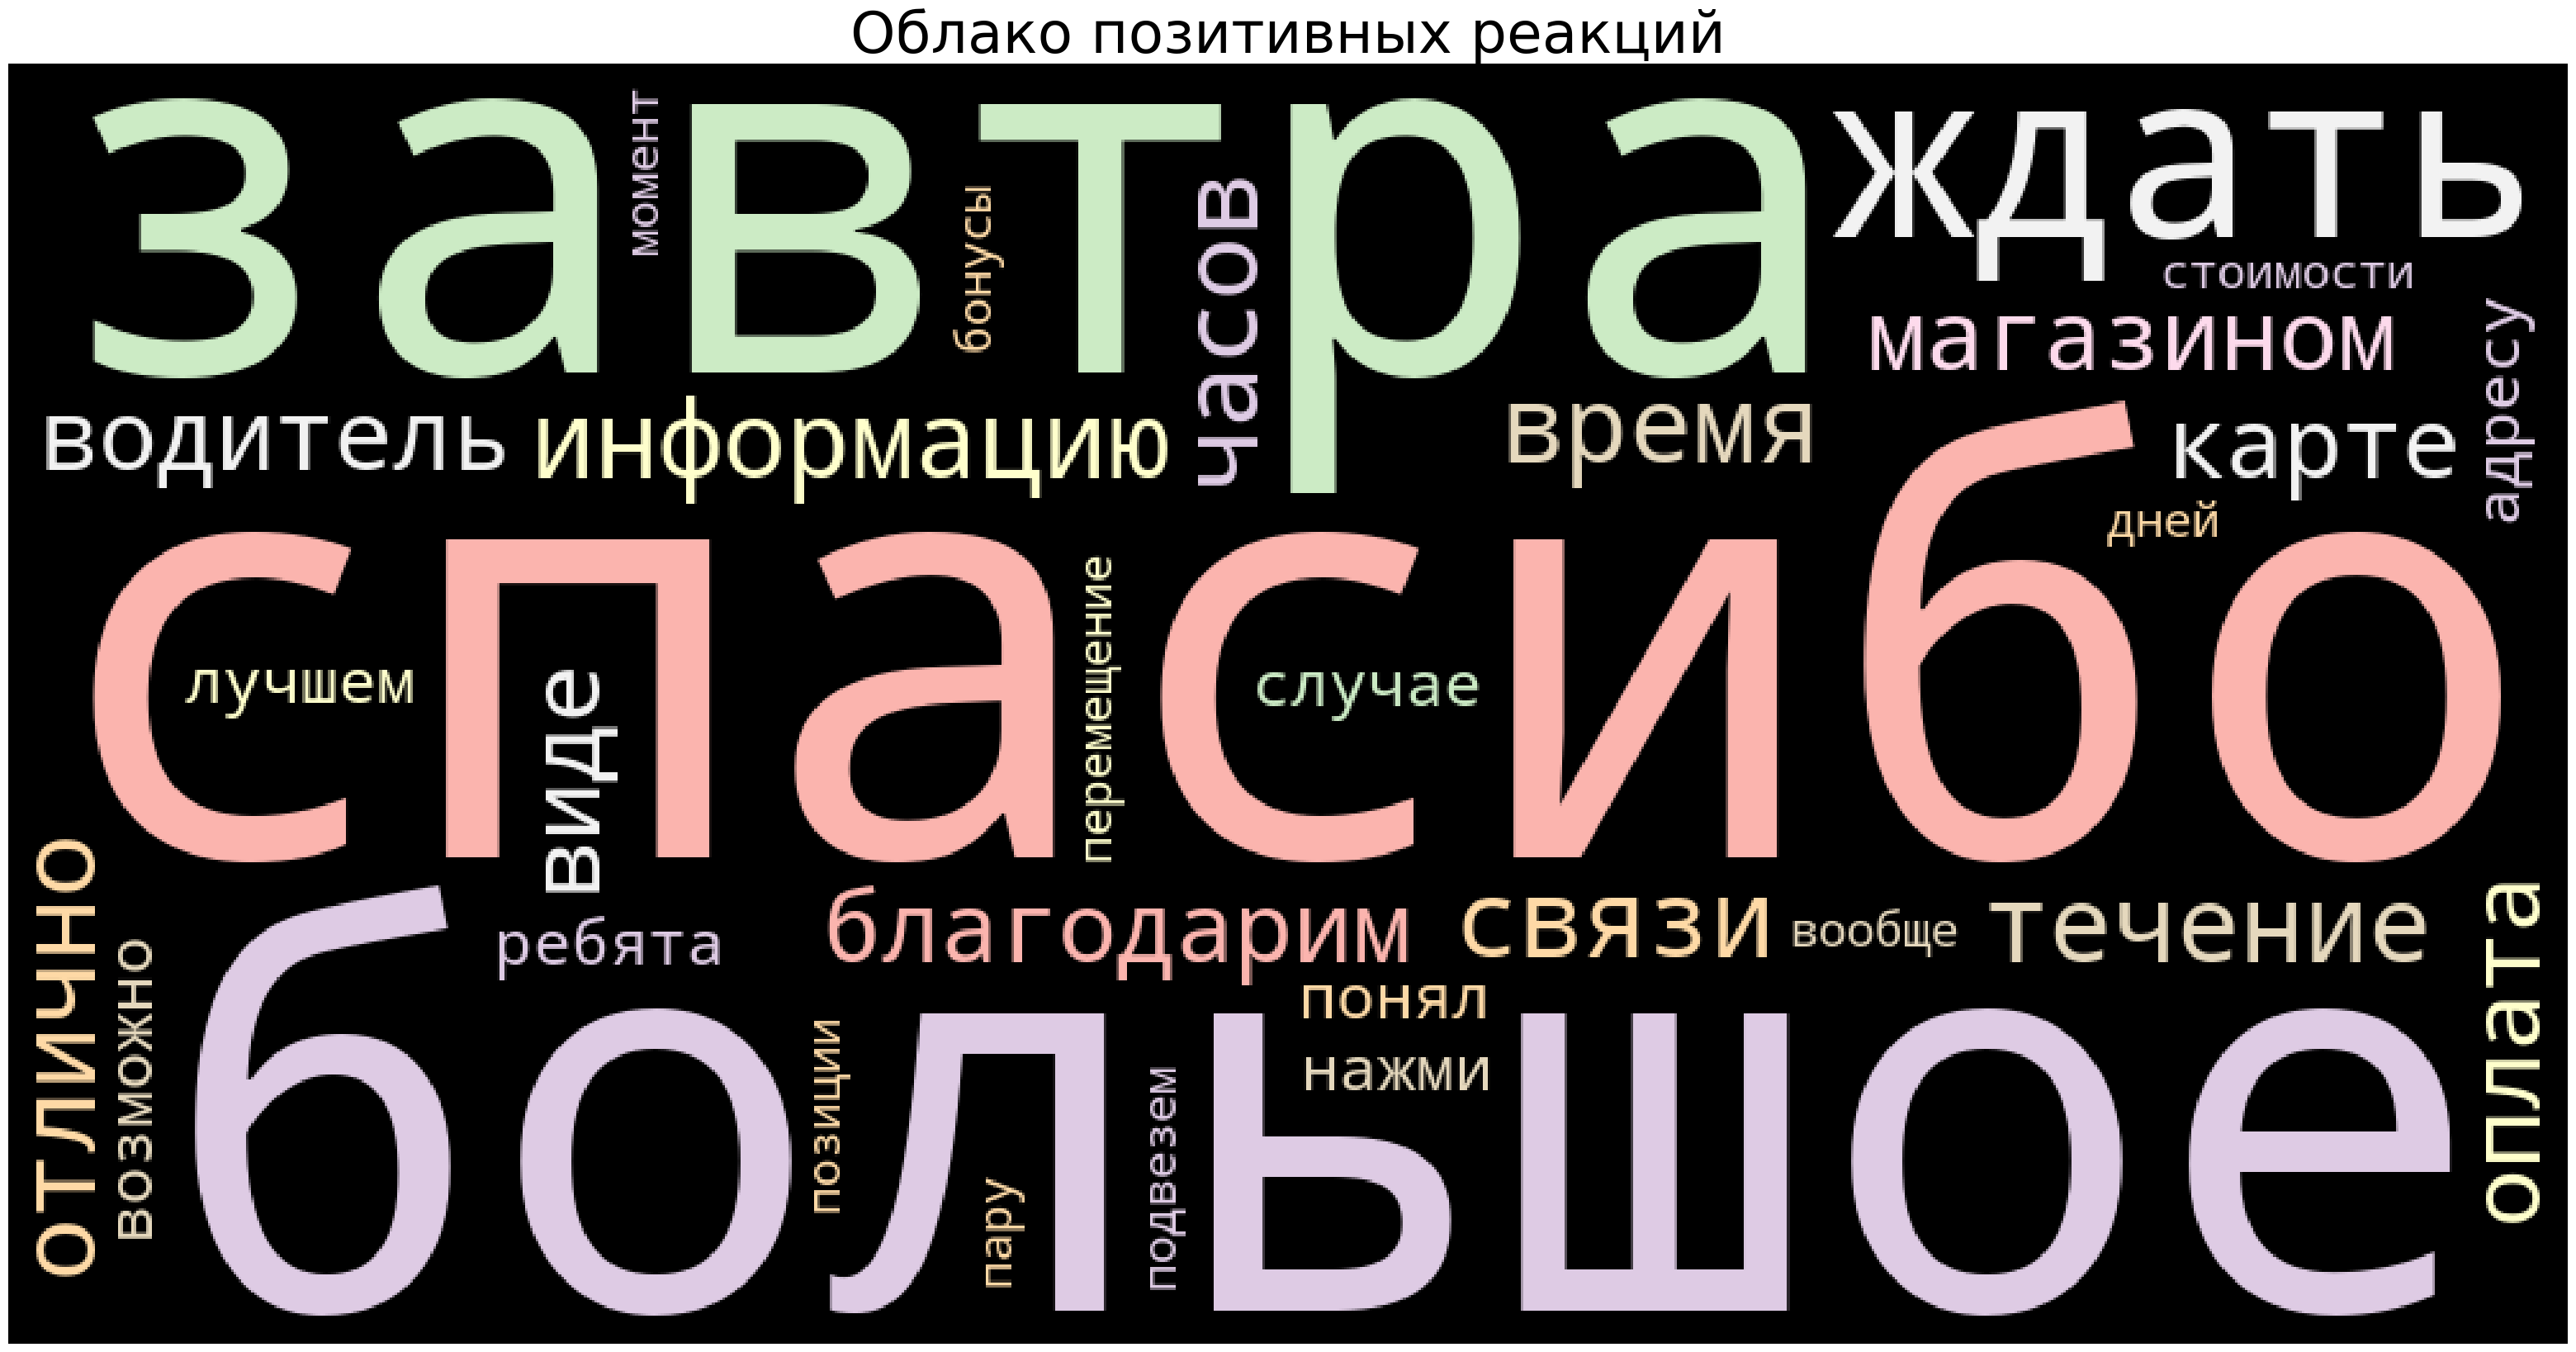

In [88]:

# Генерируем облако позитивных слов
wordcloud = WordCloud(width = 1000, 
                      height = 500, 
                      random_state=1, 
                      background_color='black', 
                      margin=20, 
                      colormap='Pastel1', 
                      collocations=False).generate(keys_50_positive)
                 
# Рисуем картинку
plot_cloud(wordcloud)
plt.title('Облако позитивных реакций', fontsize=50);

In [89]:
keys_50_negative=str(list(keys_50_negative))

words_50_negative = keys_50_negative.split()
words_50_negative = words_50_negative[:50]
keys_50_negative = " ".join(words_50_negative)
keys_50_negative=keys_50_negative.replace(",", "")
keys_50_negative=keys_50_negative.replace("'", "")
keys_50_negative

'[нормально посмотрим наверное хотели правильно передали именно вашей консультант кирилл заказу хотел общем беспокоит октября сожалению уточнить стороны доставку отдел доставки нажимала филиал доставка служба доставочки назад проверим которая коллеги формирования вашему]'

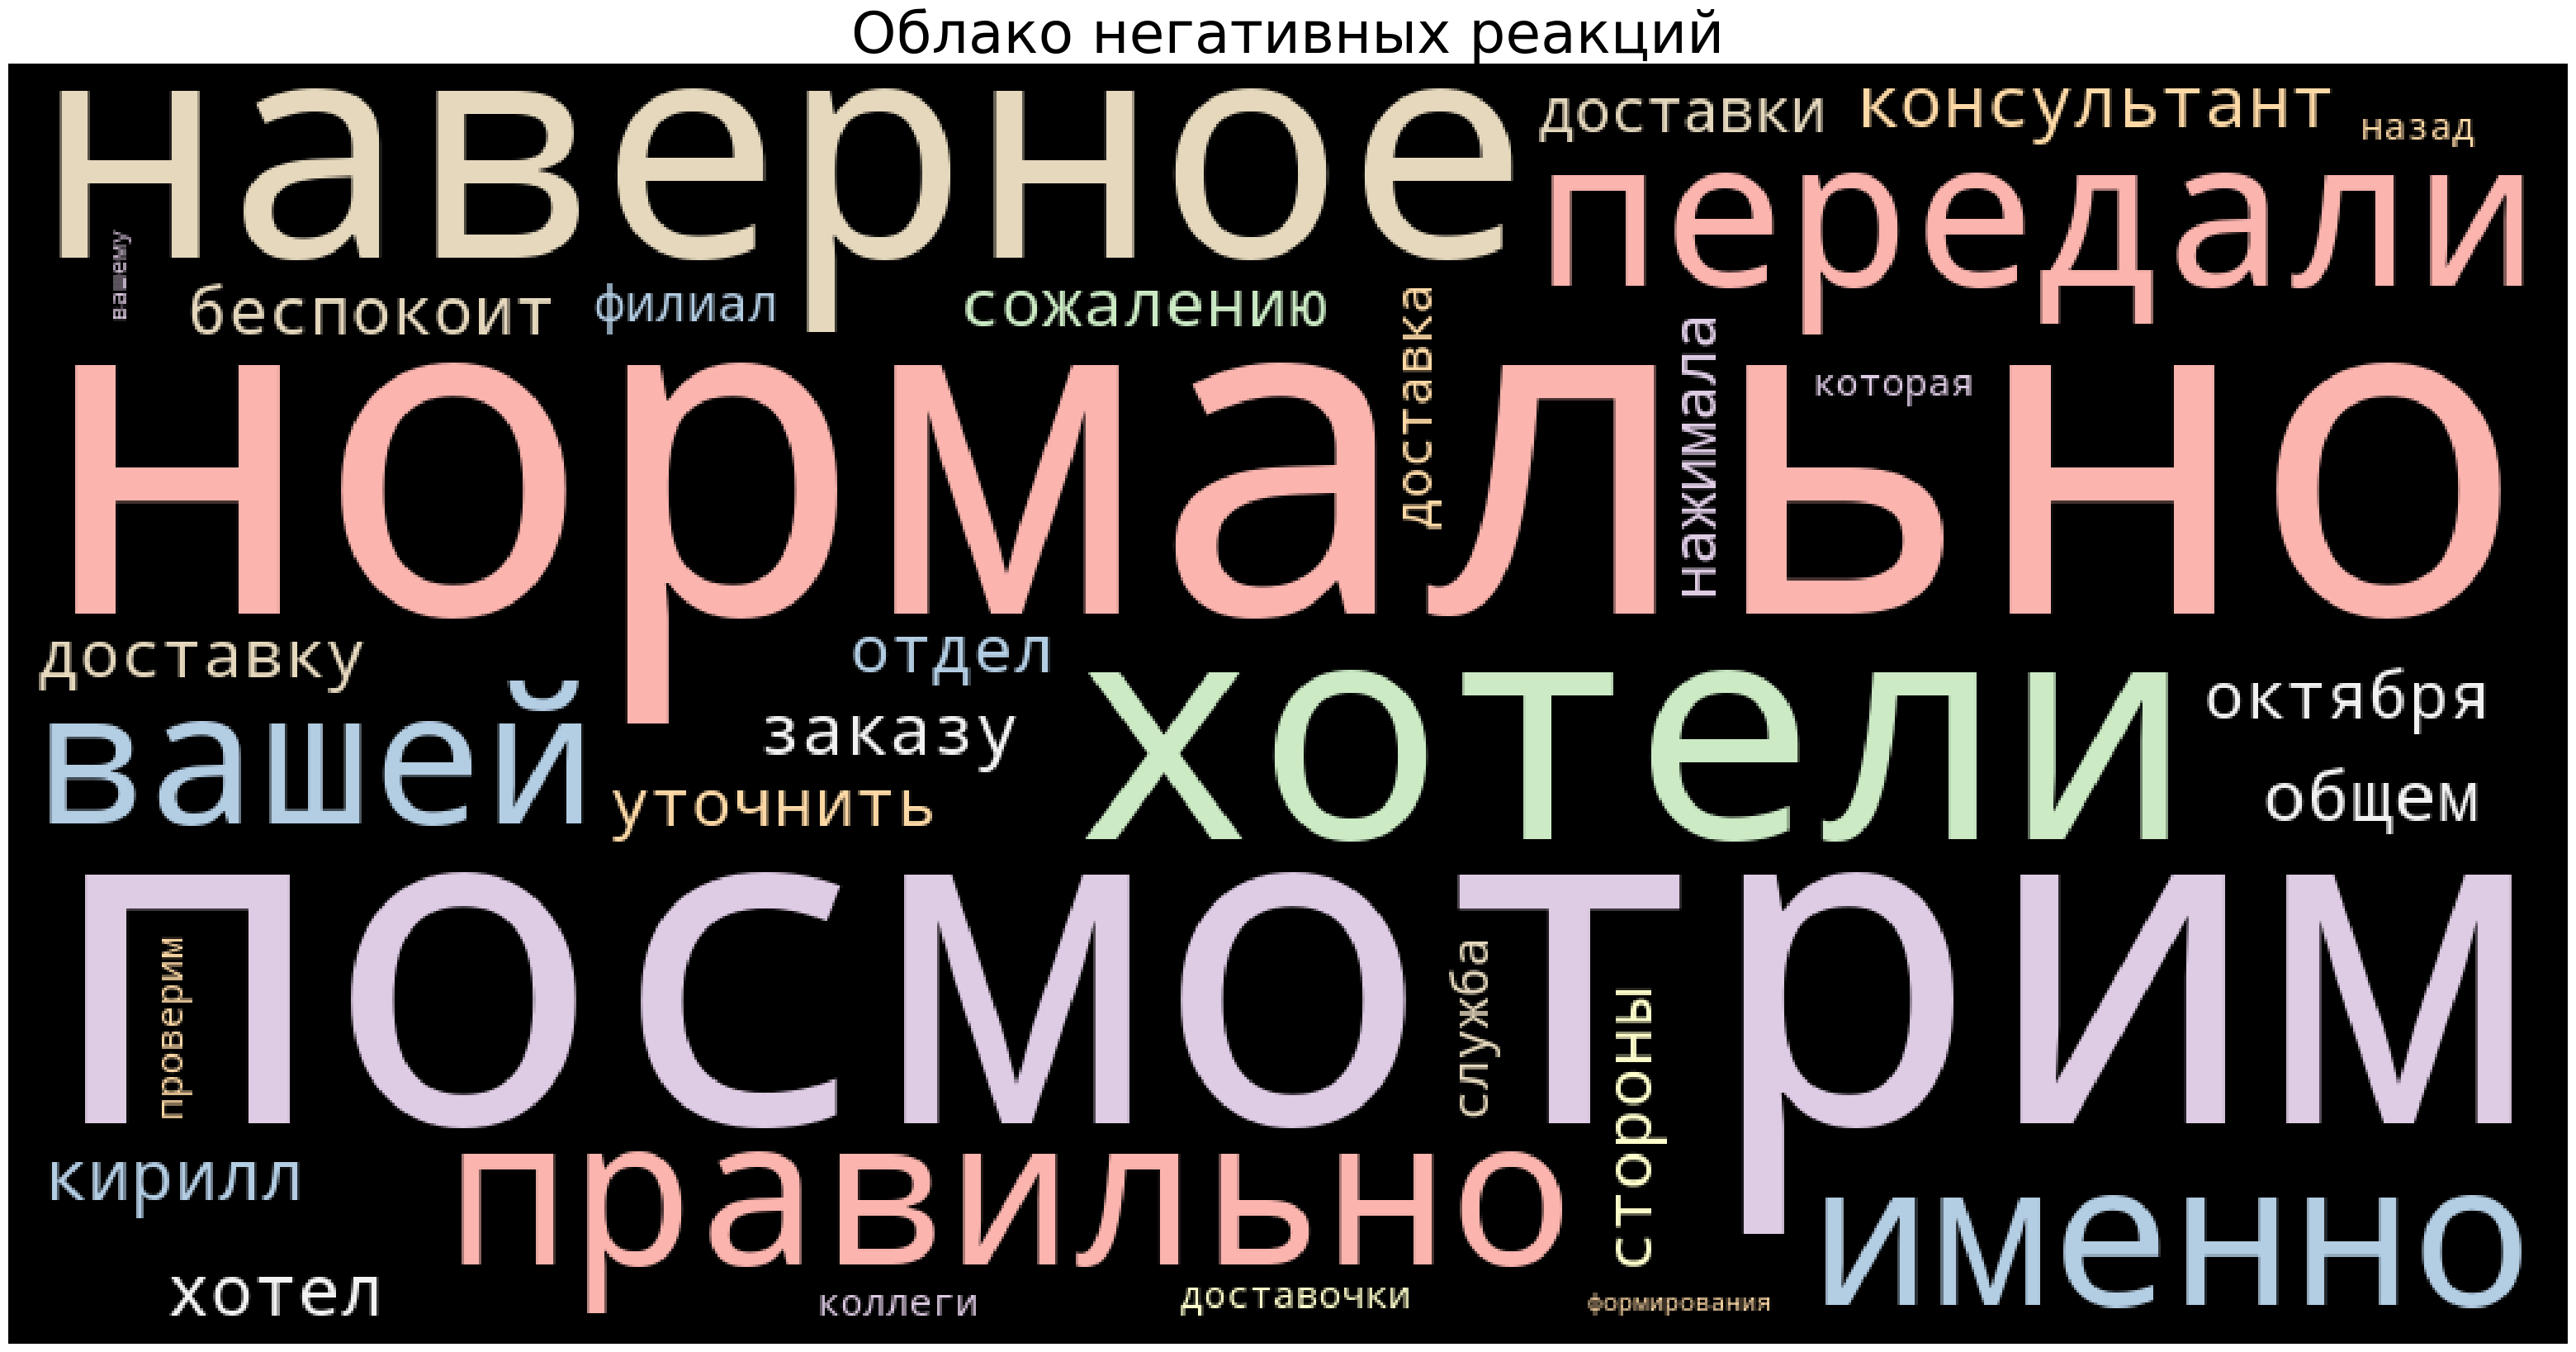

In [112]:

# Генерируем облако позитивных слов
wordcloud = WordCloud(width = 1000, 
                      height = 500, 
                      random_state=1, 
                      background_color='black', 
                      margin=20, 
                      colormap='Pastel1', 
                      collocations=False).generate(keys_50_negative)
                 
# Рисуем картинку
plot_cloud(wordcloud)
plt.title('Облако негативных реакций', fontsize=50);